In [11]:
# Importing necessary libraries
import pandas as pd
import os
import numpy as np
import struct
import cv2
import time
import albumentations as A
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Tensor Flow libraries for Model training
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, Bidirectional, Flatten, concatenate, Dropout
from tensorflow.keras.optimizers import Adam, SGD, Adagrad
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, f1_score, recall_score, accuracy_score, precision_score

In [5]:
from keras.utils import plot_model
from IPython.display import Image

## Label Extraction from integrated Red Pitaya sensor files

In [ ]:
# Extracting labels from ultrasonic data filenames
def extract_label_ultrasonic(filename):
    # mapping both "o" and "c" as an object, mapping person as "1" and object as "0."
	label_map = {"p": "1", "o": "0", "c": "0"}  
	label_key = os.path.splitext(os.path.basename(filename))[0].split("_")[2].lower()
	return label_map.get(label_key, "unknown")

# Function to convert ultrasonic data from .npy to CSV format and extract labels
def convert_ultrasonic_to_csv(ultrasonic_sensor_folder, output_csv):
	dataframes = []
	for root, dirs, files in os.walk(ultrasonic_sensor_folder):
    	for file in files:
        	if file.endswith(".npy"):
            	filepath = os.path.join(root, file)
            	data = np.load(filepath)
            	data_bytes = data.tobytes()
            	ultrasonic_data = []
            	for i in struct.iter_unpack('@h', data_bytes[64:]):
                	ultrasonic_data.append(i[0])
            	tmp_df = pd.DataFrame([ultrasonic_data])
            	label_output = extract_label_ultrasonic(file)
            	tmp_df.insert(0, "label", [label_output])
            	dataframes.append(tmp_df)
	final_dataframe = pd.concat(dataframes, ignore_index=True)
	final_dataframe.to_csv(output_csv, index=False)
    
# Define the input paths
ultrasonic_sensor_folder = r'C:\Users\yousuf\source\repos\IndividualProject_Mr.PechThesisDataset&Model\ThesisModel\Thesis_Datasets(WithLabels)\ultrasonic_sensor_data'
output_csv = r'C:\Users\yousuf\source\repos\IndividualProject_Mr.PechThesisDataset&Model\ThesisModel\RoughDataFile'
# Process integrated RP and sensor data
convert_ultrasonic_to_csv(ultrasonic_sensor_folder, output_csv)


## Input Data Loading

In [5]:
# Loading the input filepath
fft_data = pd.read_csv(r'C:\Users\yousuf\source\repos\IndividualProject_Mr.PechThesisDataset&Model\ThesisModel\Thesis_Datasets(WithLabels)\ultrasonic_sensor_data\FFT_Labeled_Data_70K.csv')
fft_data.shape

(136425, 86)

# Model Feature Extraction

In [6]:
# Extracting features (excluding the first column which has the labels)
X_fft = fft_data.iloc[:, 1:].values

# Extracting labels (using the first column as the labels)
y_fft = fft_data.iloc[:, 0].values.astype(int)


In [7]:
# Display the shapes of features and labels to verify the extraction
print("\nShape of features (X_fft):", X_fft.shape)
print("Shape of labels (y_fft):", y_fft.shape)



Shape of features (X_fft): (136425, 85)
Shape of labels (y_fft): (136425,)


## Data Splitting

In [8]:
# Splitting training & testing set parameters
X_fft_train, X_fft_test, y_fft_train, y_fft_test = train_test_split(X_fft, y_fft, test_size=0.3, random_state=42)


In [9]:
# Display the shapes of the training and testing sets
print("\nShapes of input data:")
print("X_fft_train shape:", X_fft_train.shape)
print("X_fft_test shape:", X_fft_test.shape)

print("\nShapes of labels:")
print("y_fft_train shape:", y_fft_train.shape)
print("y_fft_test shape:", y_fft_test.shape)

# Distribution of labels in both sets
print("\nDistribution of labels in the training set:")
print(pd.Series(y_fft_train).value_counts())

print("\nDistribution of labels in the testing set:")
print(pd.Series(y_fft_test).value_counts())




Shapes of input data:
X_fft_train shape: (95497, 85)
X_fft_test shape: (40928, 85)

Shapes of labels:
y_fft_train shape: (95497,)
y_fft_test shape: (40928,)

Distribution of labels in the training set:
1    51491
0    44006
Name: count, dtype: int64

Distribution of labels in the testing set:
1    21908
0    19020
Name: count, dtype: int64


In [10]:
# Combine the test features and labels into a single DataFrame
X_fft_test_df = pd.DataFrame(X_fft_test)
y_fft_test_df = pd.DataFrame(y_fft_test, columns=['label'])
test_data_df = pd.concat([y_fft_test_df, X_fft_test_df], axis=1)

# Save the DataFrame as a CSV file
test_data_df.to_csv('TestData.csv', index=False)

print("Test data has been saved to 'X_fft_test_with_labels.csv'")


Test data has been saved to 'X_fft_test_with_labels.csv'


# Model Architecture Design

In [8]:
# Building LSTM architecture with layers
rnn_lstm_model = Sequential()
rnn_lstm_model.add(LSTM(64, input_shape=(X_fft_train.shape[1], 1), return_sequences=True))
rnn_lstm_model.add(Dropout(0.5))
rnn_lstm_model.add(LSTM(64, return_sequences=True))  # Second LSTM layer
rnn_lstm_model.add(Dropout(0.5))
rnn_lstm_model.add(LSTM(64))  # Third LSTM layer, no return_sequences=True
rnn_lstm_model.add(Dropout(0.5))
rnn_lstm_model.add(Dense(1, activation='sigmoid'))



C:\Users\a.nalakath\AppData\Local\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
# Get the number of trainable parameters
trainable_params = rnn_lstm_model.count_params()
print(f"Number of trainable parameters: {trainable_params}")

Number of trainable parameters: 83009


# Model Implementation

Epoch 1/50
2985/2985 ━━━━━━━━━━━━━━━━━━━━ 464s 154ms/step - accuracy: 0.6736 - loss: 0.5612 - val_accuracy: 0.8187 - val_loss: 0.4135
Epoch 2/50
2985/2985 ━━━━━━━━━━━━━━━━━━━━ 498s 167ms/step - accuracy: 0.8425 - loss: 0.3660 - val_accuracy: 0.9259 - val_loss: 0.2046
Epoch 3/50
2985/2985 ━━━━━━━━━━━━━━━━━━━━ 489s 164ms/step - accuracy: 0.9234 - loss: 0.2140 - val_accuracy: 0.9443 - val_loss: 0.1609
Epoch 4/50
2985/2985 ━━━━━━━━━━━━━━━━━━━━ 479s 160ms/step - accuracy: 0.9391 - loss: 0.1747 - val_accuracy: 0.9565 - val_loss: 0.1285
Epoch 5/50
2985/2985 ━━━━━━━━━━━━━━━━━━━━ 496s 166ms/step - accuracy: 0.9476 - loss: 0.1551 - val_accuracy: 0.9631 - val_loss: 0.1136
Epoch 6/50
2985/2985 ━━━━━━━━━━━━━━━━━━━━ 465s 156ms/step - accuracy: 0.9557 - loss: 0.1340 - val_accuracy: 0.9634 - val_loss: 0.1109
Epoch 7/50
2985/2985 ━━━━━━━━━━━━━━━━━━━━ 424s 142ms/step - accuracy: 0.9572 - loss: 0.1303 - val_accuracy: 0.9537 - val_loss: 0.1324
Epoch 8/50
2985/2985 ━━━━━━━━━━━━━━━━━━━━ 457s 153ms/step - ac

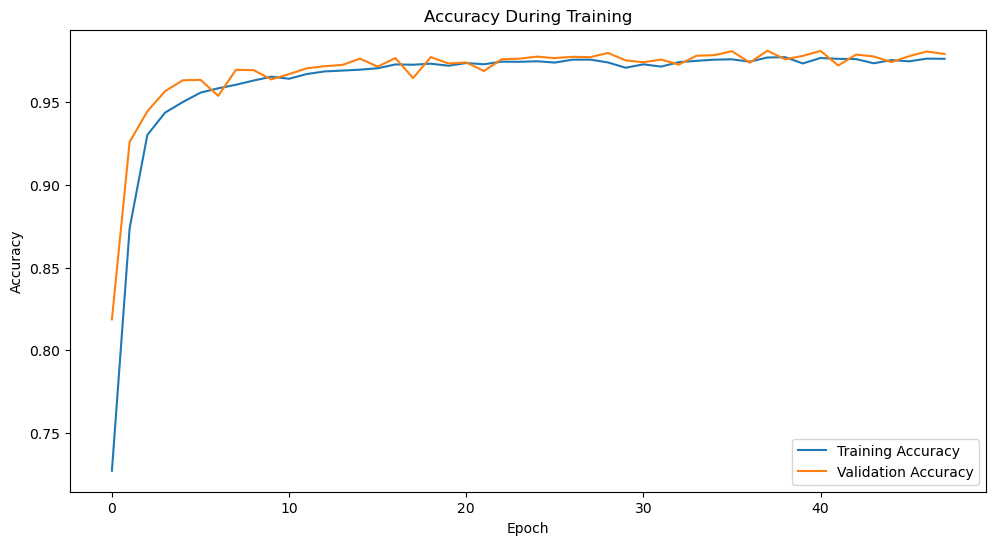

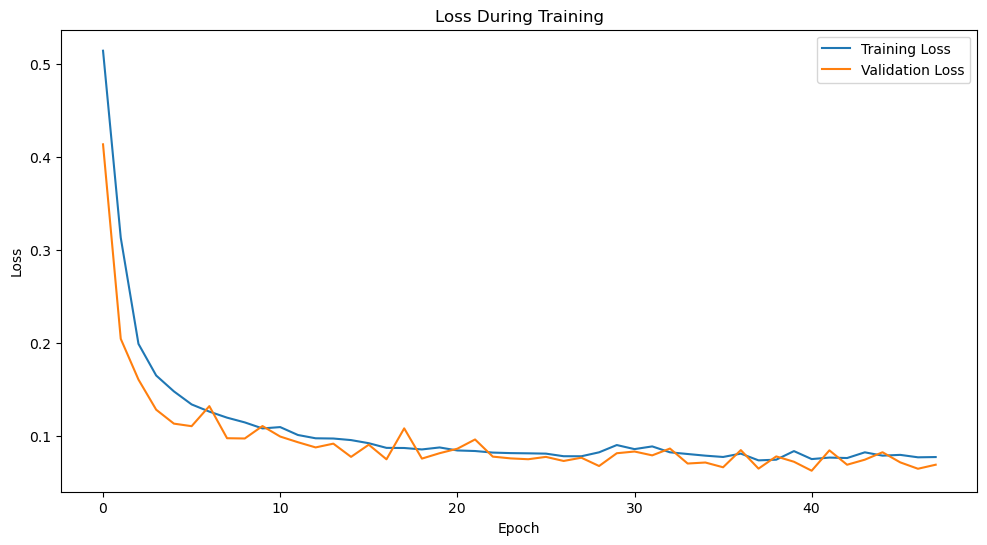

2985/2985 ━━━━━━━━━━━━━━━━━━━━ 186s 62ms/step
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 80s 63ms/step


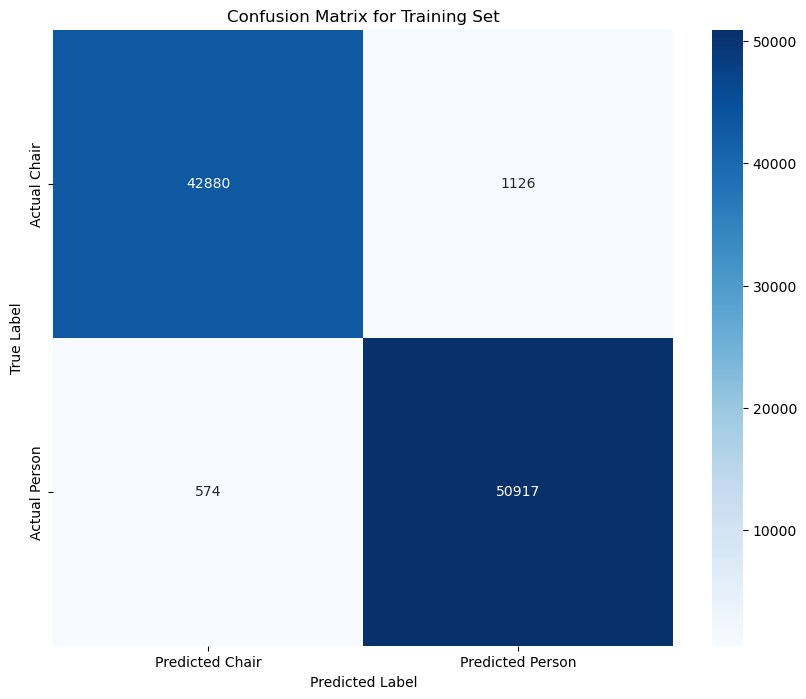

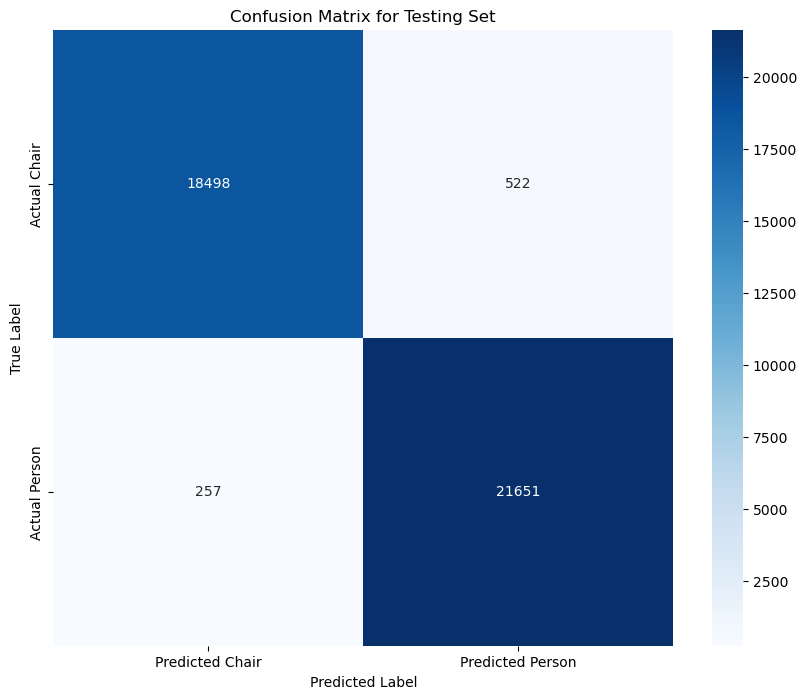

Confusion Matrix for Training Set:
[[42880  1126]
 [  574 50917]]

Confusion Matrix for Testing Set:
[[18498   522]
 [  257 21651]]

Other Relevant Parameters for Training Set:
Accuracy: 0.9822
Precision: 0.9784
Recall: 0.9889
F1 Score: 0.9836
ROC AUC Score: 0.9816
Average Precision Score: 0.9735

Other Relevant Parameters for Testing Set:
Accuracy: 0.9810
Precision: 0.9765
Recall: 0.9883
F1 Score: 0.9823
ROC AUC Score: 0.9804
Average Precision Score: 0.9713


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 85, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 85, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 85, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 85, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 249,029 (972.77 KB)

 Trainable params: 83,009 (324.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 166,020 (648.52 KB)

AttributeError: module 'pydot' has no attribute 'InvocationException'

In [10]:
# Compile the rnn-lstm model
rnn_lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks for model's performance monitoring
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_rnn_lstm_model.weights.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=True)
         	 
# Start training time
start_time = time.time()

# Train the LSTM model and store the training history
history = rnn_lstm_model.fit(X_fft_train.reshape(X_fft_train.shape[0], X_fft_train.shape[1], 1), y_fft_train, 
                             epochs=50, batch_size=32, validation_data=(X_fft_test.reshape(X_fft_test.shape[0], 
                            X_fft_test.shape[1], 1), y_fft_test), callbacks=[early_stopping, checkpoint])

# End training time
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")


# Evaluation of the LSTM model on test data
test_loss, test_acc = rnn_lstm_model.evaluate(X_fft_test.reshape(X_fft_test.shape[0], X_fft_test.shape[1], 1), y_fft_test)
print(f'Test accuracy: {test_acc:.4f}')
print(f'Test loss: {test_loss:.4f}')

# Predictions on the test set
y_pred_probs = rnn_lstm_model.predict(X_fft_test.reshape(X_fft_test.shape[0], X_fft_test.shape[1], 1))
y_pred_labels = (y_pred_probs > 0.5).astype(int)

# Evaluate the model using predicted probabilities and true labels
test_roc_auc = roc_auc_score(y_fft_test, y_pred_labels)
test_avg_precision = average_precision_score(y_fft_test, y_pred_labels)

# Accuracy score on test data
print(f'Test ROC AUC score: {test_roc_auc:.4f}')
print(f'Test Average Precision score: {test_avg_precision:.4f}')


# Plotting accuracy and loss plot on LSTM model training
# Plotting accuracy and loss during training and testing
plt.figure(figsize=(26, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy During Training')
plt.legend()

plt.figure(figsize=(26, 6))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss During Training')
plt.legend()

plt.show()


# Confusion matrix for training set
y_train_pred = (rnn_lstm_model.predict(X_fft_train.reshape(X_fft_train.shape[0], X_fft_train.shape[1], 1)) > 0.5).astype(int)
train_conf_matrix = confusion_matrix(y_fft_train, y_train_pred)

# Confusion matrix for testing set
y_test_pred = (rnn_lstm_model.predict(X_fft_test.reshape(X_fft_test.shape[0], X_fft_test.shape[1], 1)) > 0.5).astype(int)
test_conf_matrix = confusion_matrix(y_fft_test, y_test_pred)

# Plot confusion matrix for training set
plt.figure(figsize=(10, 8))
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Chair', 'Predicted Person'], yticklabels=['Actual Chair', 'Actual Person'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Training Set')
plt.show()

# Plot confusion matrix for testing set
plt.figure(figsize=(10, 8))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Chair', 'Predicted Person'], yticklabels=['Actual Chair', 'Actual Person'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Testing Set')
plt.show()

# Other relevant parameters for training set
train_accuracy = accuracy_score(y_fft_train, y_train_pred)
train_precision = precision_score(y_fft_train, y_train_pred)
train_recall = recall_score(y_fft_train, y_train_pred)
train_f1_score = f1_score(y_fft_train, y_train_pred)
train_roc_auc = roc_auc_score(y_fft_train, y_train_pred)
train_avg_precision = average_precision_score(y_fft_train, y_train_pred)

# Other relevant parameters for testing set
test_accuracy = accuracy_score(y_fft_test, y_test_pred)
test_precision = precision_score(y_fft_test, y_test_pred)
test_recall = recall_score(y_fft_test, y_test_pred)
test_f1_score = f1_score(y_fft_test, y_test_pred)
test_roc_auc = roc_auc_score(y_fft_test, y_test_pred)
test_avg_precision = average_precision_score(y_fft_test, y_test_pred)

# Print confusion matrices and other relevant parameters
print("Confusion Matrix for Training Set:")
print(train_conf_matrix)
print("\nConfusion Matrix for Testing Set:")
print(test_conf_matrix)
print("\nOther Relevant Parameters for Training Set:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1 Score: {train_f1_score:.4f}")
print(f"ROC AUC Score: {train_roc_auc:.4f}")
print(f"Average Precision Score: {train_avg_precision:.4f}")
print("\nOther Relevant Parameters for Testing Set:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1_score:.4f}")
print(f"ROC AUC Score: {test_roc_auc:.4f}")
print(f"Average Precision Score: {test_avg_precision:.4f}")


# Load the model weights
rnn_lstm_model.load_weights('best_rnn_lstm_model.weights.h5')

# Save the model with weights in Keras TensorFlow format
tf.keras.models.save_model(rnn_lstm_model, 'rnn_lstm_model.keras')


# Model Summary
rnn_lstm_model.summary()

# Visualize the model
plot_model(rnn_lstm_model, to_file='lstm_model.png', show_shapes=True, show_layer_names=True)

# Display model
Image(filename='lstm_model.png')

In [14]:
# Visualize the model
plot_model(rnn_lstm_model, to_file='lstm_model.png', show_shapes=True, show_layer_names=True)

# Display model
Image(filename='lstm_model.png')

AttributeError: module 'pydot' has no attribute 'InvocationException'

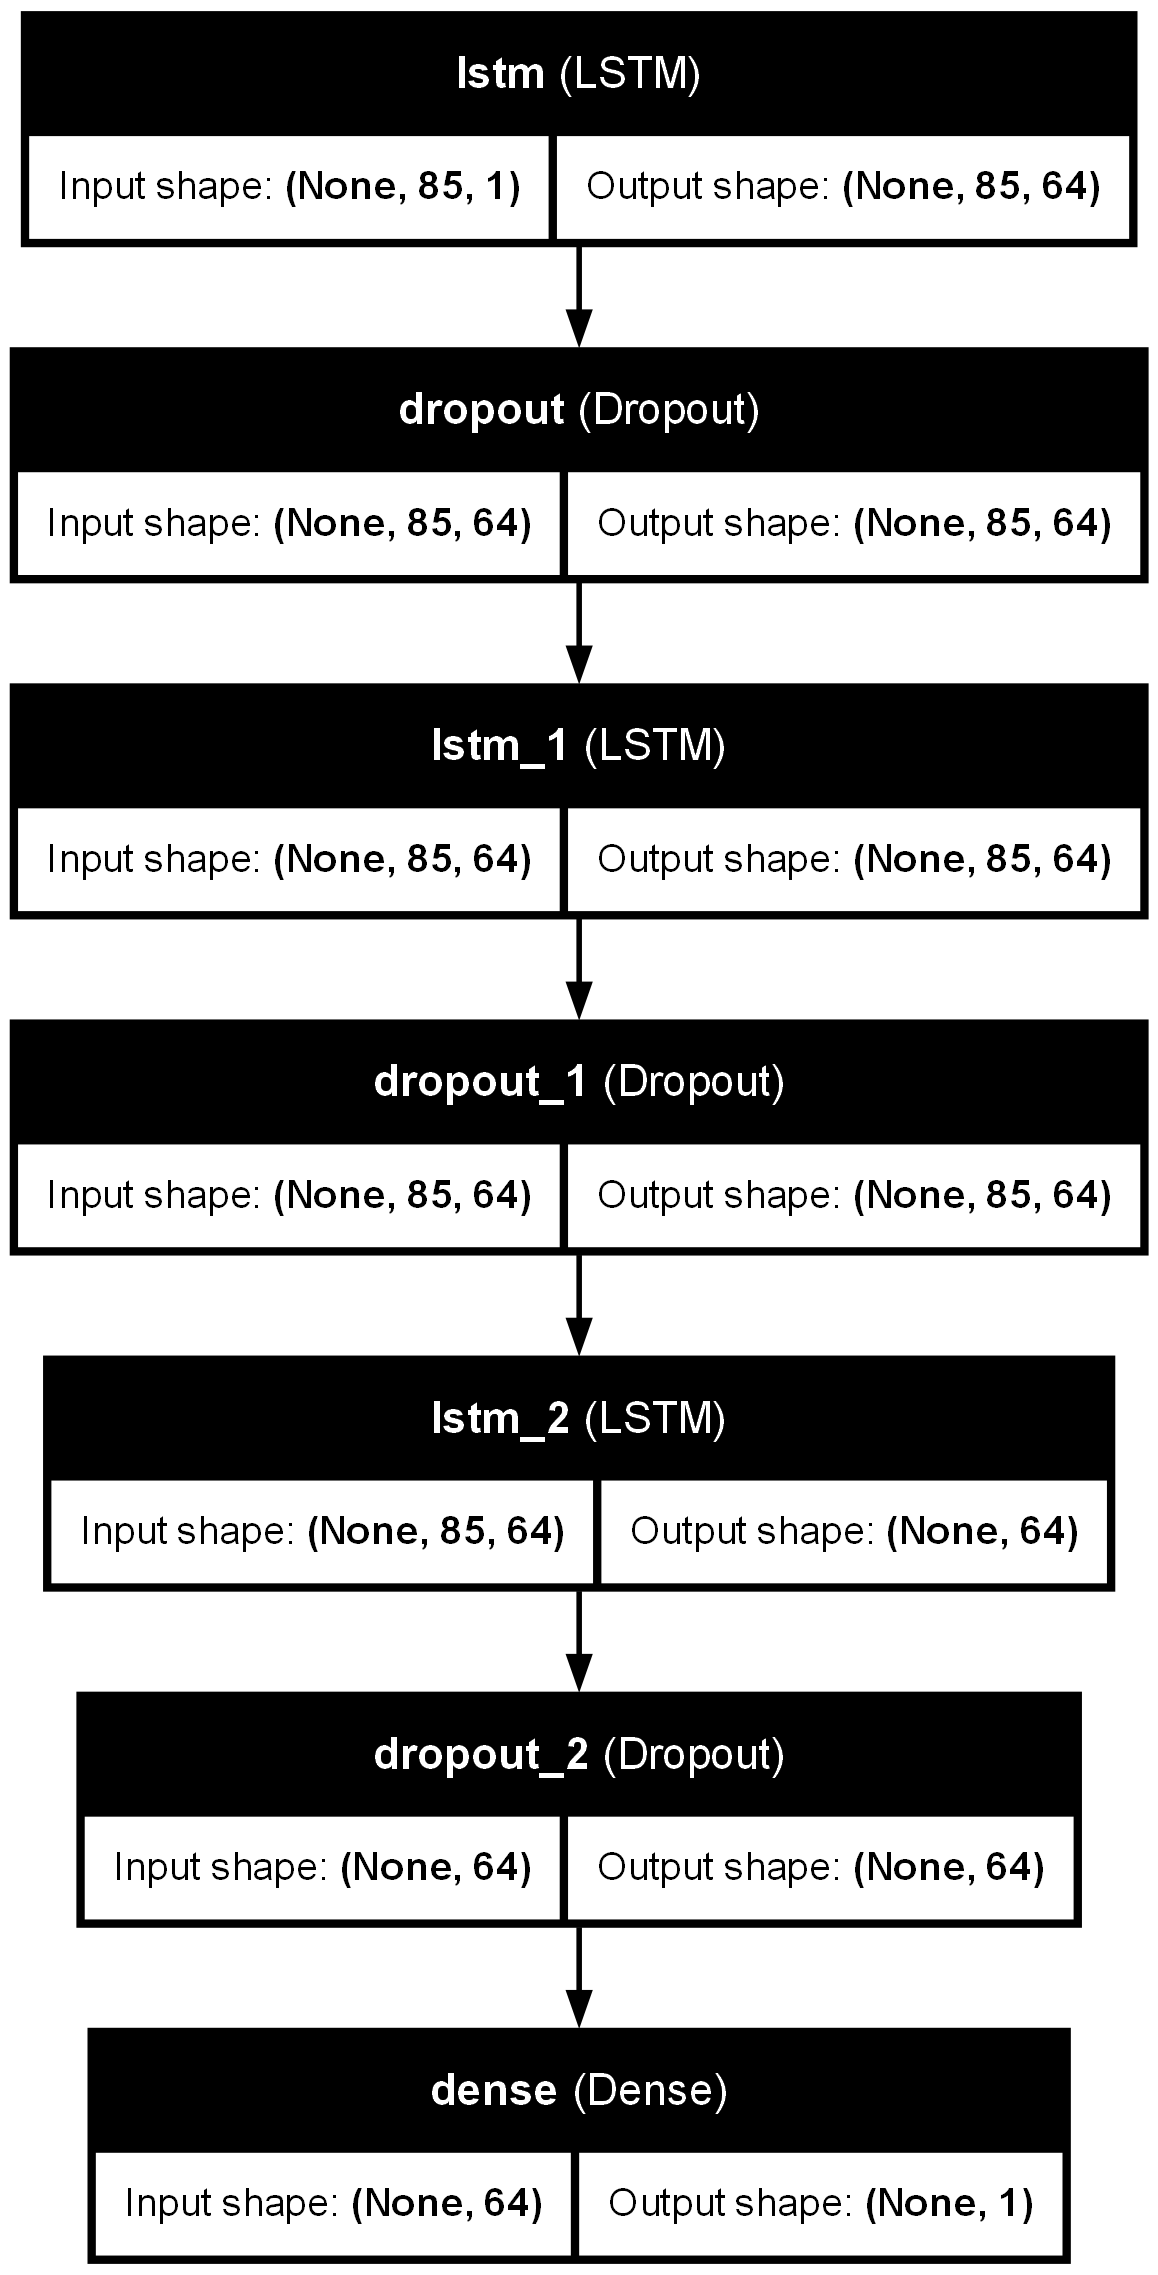

In [15]:
from keras.utils import plot_model
from IPython.display import Image
import pydotplus
import os

# Ensure Graphviz is in the PATH
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'  # Adjust this path if necessary

# Visualize the model
plot_model(rnn_lstm_model, to_file='lstm_model.png', show_shapes=True, show_layer_names=True)

# Display model
Image(filename='lstm_model.png')


2985/2985 ━━━━━━━━━━━━━━━━━━━━ 191s 64ms/step


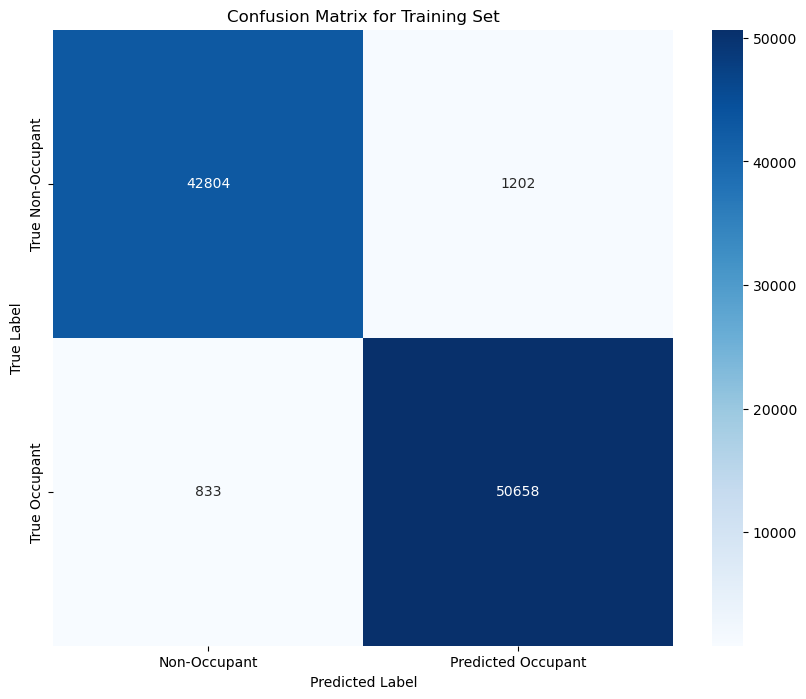

Confusion Matrix for Training Set:
[[42804  1202]
 [  833 50658]]

Revelant Performance Metrics for Training Set:
Accuracy: 0.9787
Precision: 0.9768
Recall: 0.9838
F1 Score: 0.9803
ROC AUC Score: 0.9783
Average Precision Score: 0.9697


In [33]:
# Confusion matrix for training set
y_train_pred = (rnn_lstm_model.predict(X_fft_train.reshape(X_fft_train.shape[0], X_fft_train.shape[1], 1)) > 0.5).astype(int)
train_conf_matrix = confusion_matrix(y_fft_train, y_train_pred)

# Plot confusion matrix for training set
plt.figure(figsize=(10, 8))
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Occupant', 'Predicted Occupant'], yticklabels=['True Non-Occupant', 'True Occupant'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Training Set')
plt.show()

# Revelant Performance Metrics on Training Dataset
train_accuracy = accuracy_score(y_fft_train, y_train_pred)
train_precision = precision_score(y_fft_train, y_train_pred)
train_recall = recall_score(y_fft_train, y_train_pred)
train_f1_score = f1_score(y_fft_train, y_train_pred)
train_roc_auc = roc_auc_score(y_fft_train, y_train_pred)
train_avg_precision = average_precision_score(y_fft_train, y_train_pred)

# Print confusion matrices and other relevant parameters
print("Confusion Matrix for Training Set:")
print(train_conf_matrix)

print("\nRevelant Performance Metrics for Training Set:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1 Score: {train_f1_score:.4f}")
print(f"ROC AUC Score: {train_roc_auc:.4f}")
print(f"Average Precision Score: {train_avg_precision:.4f}")


# Confusion Matrix on Testing Data of LSTM model

1279/1279 ━━━━━━━━━━━━━━━━━━━━ 81s 63ms/step


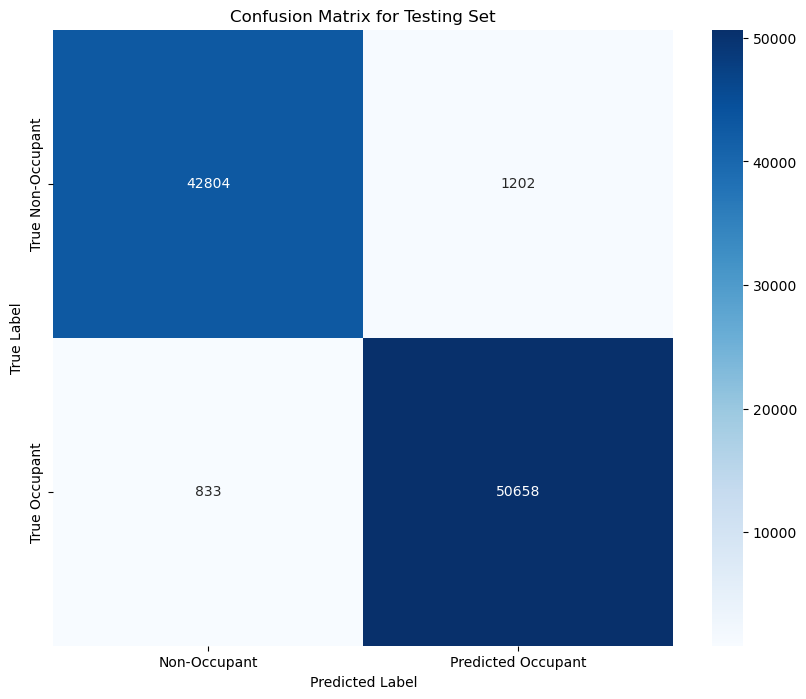


Confusion Matrix for Testing Set:
[[18474   546]
 [  396 21512]]
Relevant Performance Metrics for Testing Set:
Accuracy: 0.9770
Precision: 0.9752
Recall: 0.9819
F1 Score: 0.9786
ROC AUC Score: 0.9766


ValueError: Invalid format specifier

In [29]:
# Confusion matrix for testing set
y_test_pred = (rnn_lstm_model.predict(X_fft_test.reshape(X_fft_test.shape[0], X_fft_test.shape[1], 1)) > 0.5).astype(int)
test_conf_matrix = confusion_matrix(y_fft_test, y_test_pred)

# Plot confusion matrix for testing set
plt.figure(figsize=(10, 8))
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Occupant', 'Predicted Occupant'], yticklabels=['True Non-Occupant', 'True Occupant'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Testing Set')
plt.show()

# Revelant Performance Metrics on Testing Dataset
test_accuracy = accuracy_score(y_fft_test, y_test_pred)
test_precision = precision_score(y_fft_test, y_test_pred)
test_recall = recall_score(y_fft_test, y_test_pred)
test_f1_score = f1_score(y_fft_test, y_test_pred)
test_roc_auc = roc_auc_score(y_fft_test, y_test_pred)
test_avg_precision = average_precision_score(y_fft_test, y_test_pred)

print("\nConfusion Matrix for Testing Set:")
print(test_conf_matrix)

print("Relevant Performance Metrics for Testing Set:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1_score:.4f}")
print(f"ROC AUC Score: {test_roc_auc:.4f}")
print(f"Average Precision Score: {test_avg_precision:.4f|}")



# Graph for ROC and Test Score

Test ROC AUC score: 0.9713
Test Average Precision score: 0.9612


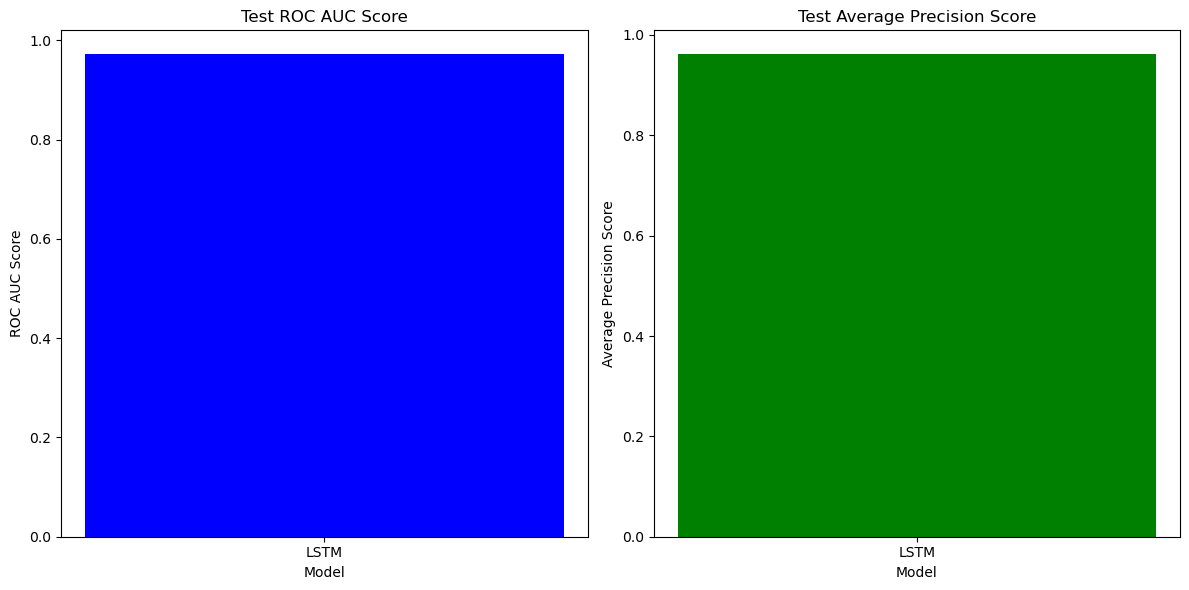

In [22]:
# Sample data: Replace these with your actual results
models = ['LSTM']
roc_auc_scores = [test_roc_auc]  # Replace with your actual ROC AUC score
average_precision_scores = [test_avg_precision]  # Replace with your actual average precision score

# Accuracy score on test data
print(f'Test ROC AUC score: {test_roc_auc:.4f}')
print(f'Test Average Precision score: {test_avg_precision:.4f}')

# Bar plot for ROC AUC and Average Precision
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(models, roc_auc_scores, color='blue')
plt.title('Test ROC AUC Score')
plt.xlabel('Model')
plt.ylabel('ROC AUC Score')

plt.subplot(1, 2, 2)
plt.bar(models, average_precision_scores, color='green')
plt.title('Test Average Precision Score')
plt.xlabel('Model')
plt.ylabel('Average Precision Score')

plt.tight_layout()
plt.show()


# Graph for Test Presicion, Recall and F1 score

Test Precision: 0.9722
Test Recall: 0.9748
Test F1 Score: 0.9735


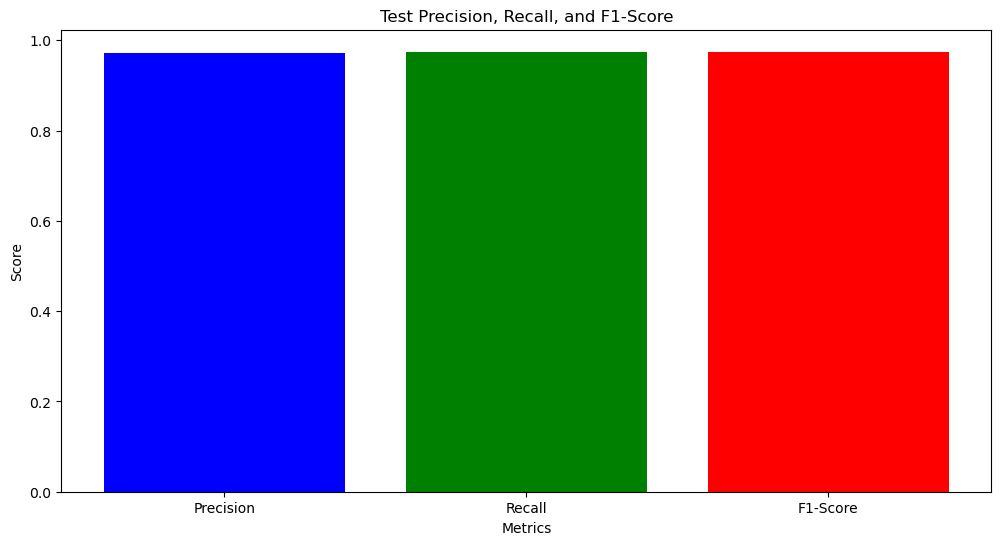

In [19]:
# Calculate precision, recall, and F1-score
test_precision = precision_score(y_fft_test, y_pred_labels)
test_recall = recall_score(y_fft_test, y_pred_labels)
test_f1 = f1_score(y_fft_test, y_pred_labels)

# Print the scores
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')

# Bar plot for Precision, Recall, and F1-Score
plt.figure(figsize=(12, 6))
scores = [test_precision, test_recall, test_f1]
metrics = ['Precision', 'Recall', 'F1-Score']
colors = ['blue', 'green', 'red']

plt.bar(metrics, scores, color=colors)
plt.title('Test Precision, Recall, and F1-Score')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.show()


# Converting the Model to a format Usable in C++ software application

In [7]:
# For TensorFlow, using TensorFlowLite to convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(rnn_lstm_model)
tflite_model = converter.convert()

with open('rnn_lstm_model.tflite', 'wb') as f:
    f.write(tflite_model)

NameError: name 'rnn_lstm_model' is not defined